In [38]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-matic-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [39]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [40]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
279,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-02,0,0,0.00,0.00,0,220147555.465170900532559201
278,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-03,12336.49493702458582540109708967138,12336.49493702458582540109708967138,24672.99,0.00,0.0001242052006398339929592103131480798,257409089.0346250359876306681059915
277,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-04,15522.22121304389566148080152237604,15522.22121304389566148080152237604,31044.44,0.00,0.0002237222637709756181174661890010285,260110640.5590329114303795093493721
276,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-05,9414.635337498668145777669596402991,9414.635337498668145777669596402989,18829.27,0.00,0.0001651559037716909806897356868275621,274922744.6763086596031594380523188
275,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-06,10161.19822121527305964058335736735,10161.19822121527305964058335736735,20322.40,0.00,0.0001735265371016202466485850822420314,270251651.0732847372851092942083257
...,...,...,...,...,...,...,...,...,...,...
316,False,0x81212149b983602474fcd0943e202f38b38d7484,Curve.fi Factory Plain Pool: ag5eur,2021-12-07,0,0,0.00,0.00,0,0
313,False,0x79b72d2afa7b9636e54bf8b7c1dd5e039e4c1d20,Curve.fi Factory Plain Pool: 4MT100,2021-12-07,0,0,0.00,0.00,0,0
310,False,0x78a8cc2a24fcc5b358bb8a371072403ce092d599,Curve.fi Factory Plain Pool: polygon aave,2021-12-07,0.000007541117572508399476321300590178355,0.000007541117572508399476321300590178355,0.00,0.00,0.0001101269865759319627555102810112316,16.26280194842827351023730774435445
346,False,0x9da618900fdea8fc300db03254394ed8eb07ef83,Curve.fi Factory USD Metapool: ibBTC,2021-12-07,0,0,0.00,0.00,0,0


<AxesSubplot:xlabel='timestamp'>

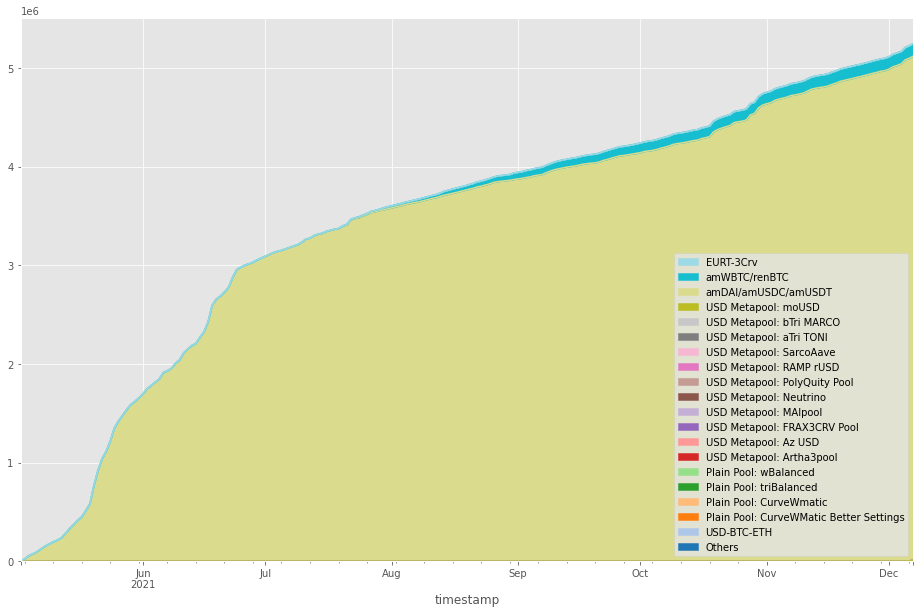

In [41]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [42]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-04-29,74546.70
2021-05-06,162213.89
2021-05-13,345943.54
2021-05-20,838891.04
2021-05-27,326169.67
2021-06-03,259328.22
2021-06-10,320294.29
2021-06-17,550695.55
2021-06-24,195836.99


In [43]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   2624991.01
dtype: float64